In [32]:
import numpy as np
import scipy.linalg as la
import scipy.optimize as opt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import colorsys
import matplotlib.colors as mc

width  = 3.402
height = width / 1.618

plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

colorsAx=['tab:red', 'tab:green', 'tab:blue']
colorsBlack=['black']*3
I = np.array([[1,0,0],[0,1,0],[0,0,1]])

def wedge(e):
    if e.shape != (3,):
        raise ValueError('Wedge: e should be a vector of length 3 and not ' + str(e.shape))
    return np.array([[0, -e[2], e[1]],
                     [e[2], 0, -e[0]],
                     [-e[1], e[0], 0]])
def vee(E):
    if E.shape != (3,3):
        raise ValueError('Wedge: e should be a 3x3 Matrix and not ' + str(E.shape))
    return np.array([E[2][1], E[0][2], E[1][0]])

def logm(R):
    theta = np.arccos((np.trace(R)-1)/2.)
    return .5 * theta/np.sin(theta) * (R - R.T)

def cot(x):
    return 1./np.tan(x)

def jac_inv(e):
    a = e/la.norm(e)
    phi=la.norm(e)
    return phi/2.*cot(phi/2.)*I + (1-phi/2.*cot(phi/2.))*xxT(a) - phi/2. * wedge(a)

def jac(e):
    if la.norm(e) < 1e-3:
        return I
        
    a = e/la.norm(e)
    phi=la.norm(e)
    
    return np.sin(phi)/phi*I + (1.-np.sin(phi)/phi)*xxT(a) + (1.-np.cos(phi))/phi*wedge(a)

def dist_rot(C1,C2, Sigmai_eps=I):
    C = np.dot(C1, C2.T)
    b = vee(logm(C))
    sigmai = np.dot(np.dot(jac(b).T, Sigmai_eps), jac(b))
    return np.dot(b.T,np.dot(sigmai,b))

def dist_rot_approx(phi,theta, Sigmai_eps=I):
    d = phi-theta
    dp = d
    if la.norm(d) > np.pi:
        dp = d * (1 - 2*np.pi/la.norm(d)) #remove 2pi

    b = np.dot(jac(phi), dp)
    sigmai = np.dot(np.dot(jac(b).T, Sigmai_eps), jac(b))
    return np.dot(b.T,np.dot(sigmai,b))

def xxT(x):
    m = np.zeros(shape=(len(x), len(x)))
    for i in range(len(m)):
        for j in range(len(m[i])):
            m[i][j] = x[i]*x[j]
    return m

#------------------------------------------------------------------------------------------
def plot_rot(ax, C, colors=colorsAx, linestyle='-', planecolor='k'):
    for v,c in zip(I, colors):
        vr = np.dot(C,v)
        ax.plot([0,vr[0]],[0,vr[1]],[0,vr[2]], color=c, linestyle=linestyle)
    for n in np.linspace(0,.3, 20):
        vx = n*np.dot(C,I[0])
        vy = n*np.dot(C,I[1])
        ax.plot(*[(vx[i],vy[i]) for i in [0,1,2]], color=planecolor)


In [33]:
theta = np.array([.5,.2,.3])
R = la.expm(wedge(theta))

print(vee(logm(R)))
print(vee(la.logm(R)))

print('-----------')
print(np.dot(jac(theta), theta))



[0.5 0.2 0.3]
[0.5 0.2 0.3]
-----------
[0.5 0.2 0.3]


[0.         0.         2.82743339]


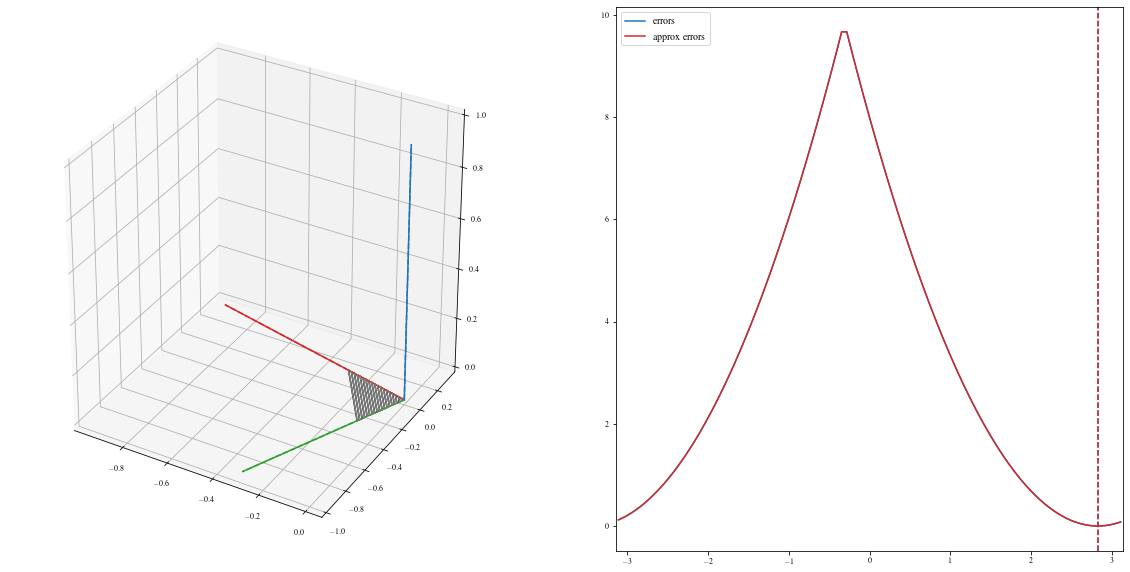

In [38]:
angle = .9*np.pi
theta = np.array([0,0,1]) #rotate around vector
theta = theta/la.norm(theta) * angle #of this angle

phi = np.array([0,0,1])
phi = phi/la.norm(phi)  #normalized

Sigma = I #standard deviation of sigma=.17
Sigmai= la.inv(Sigma)

# theta = theta_e
# phi = phi_e

CI = la.expm(wedge(theta))
Cs = lambda a: la.expm(wedge(phi * a))

print(vee(logm(np.dot(CI,Cs(0).T))))

#find best alpha
best_alpha_approx = opt.minimize(lambda alpha: dist_rot_approx(alpha*phi, theta), x0=0, options={'disp':False}).x
best_alpha = opt.minimize(lambda alpha: dist_rot(Cs(alpha), CI), x0=0, options={'disp':False}).x
#---------------

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1, projection='3d')

# plot_rot(ax,I, colorsBlack)
plot_rot(ax,Cs(best_alpha), linestyle='-')
plot_rot(ax,CI, linestyle='--', planecolor='gray')

# ---------------------------------------------------------

ax2 = fig.add_subplot(1,2,2)

alphas = np.linspace(-.99*np.pi, .99*np.pi, 100)

errs = [dist_rot(Cs(alpha),CI, Sigmai) for alpha in alphas]
ax2.plot(alphas, errs, label="errors", color='tab:blue')

errs_approx = [dist_rot_approx(alpha*phi,theta, Sigmai) for alpha in alphas]
ax2.plot(alphas, errs_approx, label="approx errors", color='tab:red')

ax2.legend()
ax2.set_xlim(-np.pi,np.pi)
# ax2.set_ylim(0,100)

ax2.axvline(best_alpha, c='tab:blue', ls='--')
ax2.axvline(best_alpha_approx, c='tab:red', ls='--')

# Measure error of approximation

In [14]:
def drawGenerator(max_ang=np.pi):
    v = np.random.uniform(0,max_ang,size=3)
    while la.norm(v) >= max_ang:
        v = np.random.uniform(0,max_ang,size=3)
    return v



## non degenerate case

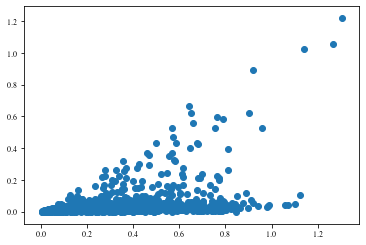

In [15]:
N=1000
Sigma = I #standard deviation of 1
Sigmai= la.inv(Sigma)

errors=np.zeros((N))
errors_approx=np.zeros((N))

for i in range(N):
    theta = drawGenerator(np.pi/3.)
    phi = drawGenerator(np.pi/3.)

    errors[i] = dist_rot(la.expm(wedge(theta)),la.expm(wedge(phi)), Sigmai) 
    errors_approx[i] = dist_rot_approx(theta,phi, Sigmai) 

plt.figure()
plt.scatter(errors, np.abs(errors-errors_approx))


# Measure error of approximation & computational time
## degenerate case

approx done


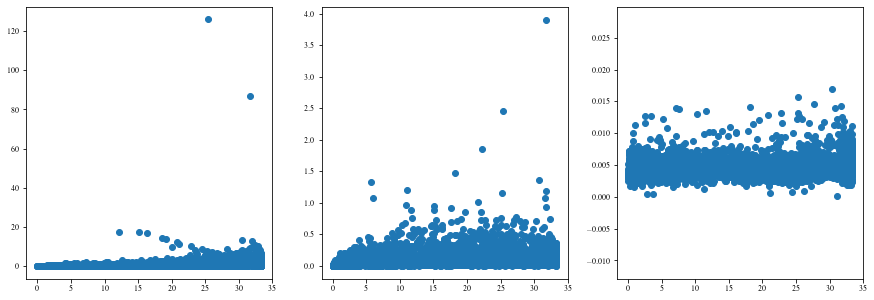

In [16]:
N=5000

Sigma = .03*I #standard deviation of 1
Sigmai= la.inv(Sigma)

errors=np.zeros((N))
errors_approx=np.zeros((N))
times=np.zeros((N))
times_approx=np.zeros((N))
alphas=np.zeros((N))
alphas_approx=np.zeros((N))

theta = np.zeros((N,3))
phi   = np.zeros((N,3))

for i in range(N):
    theta[i] = drawGenerator(np.pi/2.)
    phi[i] = drawGenerator(np.pi/2.)

for i in range(N):
    Cs = lambda a:la.expm(wedge(a*phi[i]))
    CI = la.expm(wedge(theta[i]))
    start = time.time()
    best_alpha = opt.minimize(lambda alpha: dist_rot_approx(alpha*phi[i], theta[i]), x0=0).x
    end = time.time()
    alphas_approx[i] = best_alpha
    times_approx[i] = end-start
    errors_approx[i] = dist_rot_approx(best_alpha*phi[i] ,theta[i], Sigmai)
print("approx done")
for i in range(N):
    Cs = lambda a:la.expm(wedge(a*phi[i]))
    CI = la.expm(wedge(theta[i]))
    start = time.time()
    best_alpha = opt.minimize(lambda alpha: dist_rot(Cs(alpha),CI, Sigmai), x0=0).x
    end = time.time()
    alphas[i] = best_alpha
    times[i] = end-start
    errors[i] = dist_rot(Cs(best_alpha),CI, Sigmai) 
    
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].scatter(errors, np.abs(errors-errors_approx))
axs[1].scatter(errors, np.abs(alphas-alphas_approx))
axs[2].scatter(errors, np.abs(times-times_approx))

In [17]:
#you can change it to quadratic or cubic (cf scipy interpolate doc)
interpolation_kind = "linear"

#don't touch my stuff ;) 
def getBin(x, bins):
    for i in range(len(bins)-1):
        if bins[i] <= x < bins[i+1]:
            return i
    return len(bins)-1 #last bin

def getHisto(x,y, bins):
    bins_y = [[] for i in range(len(bins))]
    
    histo_mean      = np.zeros((len(bins)))
    histo_sd        = np.zeros((len(bins)))
    histo_median    = np.zeros((len(bins)))
    histo_quantiles = np.zeros((len(bins),2)) #25%, 75%
    
    for x_,y_ in zip(x,y):
        bin_ = getBin(x_, bins)
        bins_y[bin_] = np.append(bins_y[bin_], y_)
        
    for i in range(len(bins)):
        histo_mean[i]        = np.mean   (bins_y[i]) if len(bins_y[i])>0 else None
        histo_sd[i]          = np.std    (bins_y[i]) if len(bins_y[i])>0 else None
        histo_median[i]      = np.median (bins_y[i]) if len(bins_y[i])>0 else None
        histo_quantiles[i][0]= np.quantile(bins_y[i], .25) if len(bins_y[i])>0 else None
        histo_quantiles[i][1]= np.quantile(bins_y[i], .75) if len(bins_y[i])>0 else None
    
    #filter empty histograms
    f_bins = [bins[i] + .5*((bins[i+1]-bins[i]) if i+1<len(bins) else (bins[i]-bins[i-1]))
                            for i in range(len(bins)) if len(bins_y[i])>0]
    f_histo_mean  = [histo_mean[i]   for i in range(len(bins)) if len(bins_y[i])>0]
    f_histo_sd    = [histo_sd[i]     for i in range(len(bins)) if len(bins_y[i])>0]
    f_histo_median= [histo_median[i] for i in range(len(bins)) if len(bins_y[i])>0]
    f_histo_quantiles= [(histo_quantiles[i][0],histo_quantiles[i][1])  for i in range(len(bins)) if len(bins_y[i])>0]
    
    return f_bins, f_histo_mean, f_histo_sd, f_histo_median, f_histo_quantiles

def smooth(x,y, xnew):
    f = interpolate.interp1d(x, y, kind=interpolation_kind)
    ynew = f(xnew)
    return ynew
#---------------------------------------------
def lighten_color(color, amount=0.5): #lighten or darken color
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


7.73167610168457 2.998828887939453


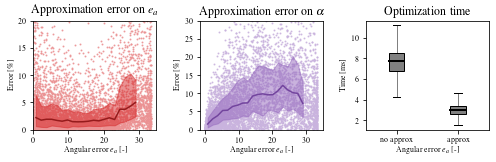

In [19]:
bins = np.linspace(min(errors), .85*max(errors), 20)
colors = ['tab:red', 'tab:purple', 'tab:green']

fig, axs = plt.subplots(1,3, figsize=(15,5))

for i,c,s,y in zip(range(2),colors, [errors, errors],
                   [[100*np.abs((e-ep)/e) for e,ep in zip(errors, errors_approx)],
                    [100*np.abs((a-ap)/a) for a,ap in zip(alphas, alphas_approx)]]):
    axs[i].scatter(errors, y, c=lighten_color(c,.5), s=1, alpha=.8)

    f_bins, f_histo_mean, f_histo_sd, f_histo_median, f_histo_quantiles = getHisto(errors, y, bins)
    axs[i].plot(f_bins, f_histo_median, c=lighten_color(c,1.3))
    axs[i].fill_between(f_bins,
             [q[0] for q in f_histo_quantiles],
             [q[1] for q in f_histo_quantiles], 
             alpha=.5, color=c)

axs[2].boxplot((1000*times, 1000*times_approx),
            showfliers=False,
            widths=0.25, patch_artist=True,
            boxprops=dict(color="black", facecolor="gray"),
            whiskerprops=dict(color="gray", linewidth=1),
            medianprops=dict(color="k", linewidth=2 ))
# axs[2].set_yscale('log')
#axs[2].set_yticks([*np.linspace(0,100,6)])#,1000*np.median(times), 1000*np.median(times_approx)])
axs[2].set_xticklabels(['no approx', 'approx'])

for ax in axs:
    ax.set_xlabel(r"Angular error $e_a$ [-]")
axs[0].set_ylabel(r"Error [\%]")
axs[1].set_ylabel(r"Error [\%]")
axs[2].set_ylabel(r"Time [ms]")
axs[0].set_title(r"Approximation error on $e_a$")
axs[1].set_title(r"Approximation error on $\alpha$")
axs[2].set_title(r"Optimization time")

axs[0].set_ylim(0,20)
axs[0].set_xlim(0,35)
axs[1].set_ylim(0,30)


fig.set_size_inches(2*width, height)
fig.subplots_adjust(left=.06, bottom=.17, right=.99, top=.89, wspace=.35)
fig.savefig('rot_errors.pdf')

print(1000*np.median(times), 1000*np.median(times_approx))